# Pré-processamento

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('df_parcial_5.txt', delimiter='\t')

In [3]:
df_sent = pd.read_csv('../ClassificadordeSentimentos/sentimentos_classificados.csv')

In [4]:
df['acao'].unique()

array(['venda', 'tratamento', 'imposto', 'multa', 'selo', 'troca taxa',
       'transferencia', 'aluguel'], dtype=object)

In [5]:
previsores = df.drop(columns=['Unnamed: 0','poluicao_mundial', 'selo','prox_taxa', 'val_taxa', 'etapa_1', 'etapa_2'])
classe = df.iloc[:, 22].values #poluicao
previsores.head()

,acao,pessoa1,pessoa2,parcela,objeto,tipo_preco,rodada,jogo,saldo_AgCD1,saldo_AgCD2,...,saldo_AgAT3,saldo_EmpAgro,saldo_EmpFert,saldo_EmpMaq,saldo_EmpSem,saldo_FiscalAT,saldo_FiscalCD,saldo_PrefeitoAT,saldo_PrefeitoCD,tratamento
0,venda,EmpSem|FiscalAT,AgAT2|VereadorAT,1.0,Soja,normal,1,5,600.0,600.0,...,600.0,100.0,100.0,100.0,130.0,0.0,0.0,1000.0,1000.0,NaN
1,venda,EmpFert,AgAT2|VereadorAT,1.0,Premium,normal,1,5,600.0,600.0,...,600.0,100.0,120.0,100.0,130.0,0.0,0.0,1000.0,1000.0,NaN
2,venda,EmpAgro,AgAT2|VereadorAT,1.0,Super premium,normal,1,5,600.0,600.0,...,600.0,130.0,120.0,100.0,130.0,0.0,0.0,1000.0,1000.0,NaN
3,venda,EmpSem|FiscalAT,AgAT2|VereadorAT,2.0,Soja,normal,1,5,600.0,600.0,...,600.0,130.0,120.0,100.0,160.0,0.0,0.0,1000.0,1000.0,NaN
4,venda,EmpFert,AgAT2|VereadorAT,2.0,Premium,normal,1,5,600.0,600.0,...,600.0,130.0,140.0,100.0,160.0,0.0,0.0,1000.0,1000.0,NaN


In [6]:
#integração entre as bases de dados
df_resultado = df[(df['pessoa1'].isin(df_sent['Emp']) & df['pessoa2'].isin(df_sent['Agro']) & df['jogo'].isin(df_sent['Partida']) & df['rodada'].isin(df_sent['Rodada']) )].dropna().reset_index(drop=True)

In [7]:
df_resultado

,Unnamed: 0,acao,pessoa1,pessoa2,parcela,objeto,tipo_preco,rodada,jogo,saldo_AgCD1,...,saldo_FiscalCD,saldo_PrefeitoAT,saldo_PrefeitoCD,poluicao_mundial,selo,prox_taxa,val_taxa,tratamento,etapa_1,etapa_2


In [8]:
#transformacao dos dados categoricos em numericos
previsores = previsores.drop(
    columns=['acao','pessoa1','pessoa2','objeto','tipo_preco','tratamento'])
previsores = pd.concat([previsores,pd.get_dummies(
    df[['acao','pessoa1','pessoa2','objeto','tipo_preco','tratamento']])], axis=1)
pd.set_option('display.max_columns', None)
previsores['parcela'].fillna(value=0, inplace=True)
previsores.head()

,parcela,rodada,jogo,saldo_AgCD1,saldo_AgCD2,saldo_AgCD3,saldo_AgAT1,saldo_AgAT2,saldo_AgAT3,saldo_EmpAgro,saldo_EmpFert,saldo_EmpMaq,saldo_EmpSem,saldo_FiscalAT,saldo_FiscalCD,saldo_PrefeitoAT,saldo_PrefeitoCD,acao_aluguel,acao_imposto,acao_multa,acao_selo,acao_transferencia,acao_tratamento,acao_troca taxa,acao_venda,pessoa1_AgAT2|PrefeitoAT,pessoa1_AgCD1|FiscalCD,pessoa1_AgCD2|PrefeitoCD,pessoa1_AgCD3|FiscalCD,pessoa1_AgCD3|PrefeitoCD,pessoa1_EmpAgro,pessoa1_EmpFert,pessoa1_EmpFert|FiscalCD,pessoa1_EmpMaq,pessoa1_EmpMaq|PrefeitoAT,pessoa1_EmpSem|FiscalAT,pessoa1_EmpSem|FiscalAT|FiscalAT,pessoa2_AgAT1,pessoa2_AgAT1|VereadorAT,pessoa2_AgAT2|PrefeitoAT,pessoa2_AgAT2|VereadorAT,pessoa2_AgAT3,pessoa2_AgCD1|FiscalCD,pessoa2_AgCD1|VereadorCD,pessoa2_AgCD2,pessoa2_AgCD2|PrefeitoCD,pessoa2_AgCD3|FiscalCD,pessoa2_AgCD3|PrefeitoCD,pessoa2_AgCD3|VereadorCD,pessoa2_EmpAgro,pessoa2_EmpFert,pessoa2_EmpFert|FiscalCD,pessoa2_EmpMaq,pessoa2_EmpMaq|PrefeitoAT,pessoa2_EmpSem|FiscalAT,objeto_Arroz,objeto_Comum,objeto_Hortalica,objeto_Maquinas 1,objeto_Maquinas 2,objeto_Maquinas 3,objeto_Premium,objeto_Pulverizador,objeto_Soja,objeto_Super premium,tipo_preco_alto,tipo_preco_baixo,tipo_preco_normal,tratamento_Agua,tratamento_Esgoto,tratamento_Lixo
0,1.0,1,5,600.0,600.0,600.0,600.0,580.0,600.0,100.0,100.0,100.0,130.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,1.0,1,5,600.0,600.0,600.0,600.0,630.0,600.0,100.0,120.0,100.0,130.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1.0,1,5,600.0,600.0,600.0,600.0,730.0,600.0,130.0,120.0,100.0,130.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,2.0,1,5,600.0,600.0,600.0,600.0,710.0,600.0,130.0,120.0,100.0,160.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,2.0,1,5,600.0,600.0,600.0,600.0,760.0,600.0,130.0,140.0,100.0,160.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [9]:
#normalizacao dos dados
X = previsores
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-0.71992062, -1.33555378, -1.09200212, ..., -0.08200185,
        -0.09815249, -0.0877058 ],
       [-0.71992062, -1.33555378, -1.09200212, ..., -0.08200185,
        -0.09815249, -0.0877058 ],
       [-0.71992062, -1.33555378, -1.09200212, ..., -0.08200185,
        -0.09815249, -0.0877058 ],
       ...,
       [-1.1920588 ,  1.35610077,  0.91574914, ..., -0.08200185,
        -0.09815249, -0.0877058 ],
       [-1.1920588 ,  1.35610077,  0.91574914, ..., -0.08200185,
        -0.09815249, -0.0877058 ],
       [-1.1920588 ,  1.35610077,  0.91574914, ..., -0.08200185,
        -0.09815249, -0.0877058 ]])

# Modelos

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
Y = classe
#separação dos dados para treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.3, random_state = 0)

Regressão Linear

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
regressaoLinear = LinearRegression()
regressaoLinear.fit(x_treino, y_treino)
score = regressaoLinear.score(x_treino, y_treino)
coeficiente = regressaoLinear.coef_
intercepcao = regressaoLinear.intercept_
previsoes = regressaoLinear.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [14]:
print('Linear Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

Linear Regression
Mean absolute error: 18.45934768385464
Mean squared error: 107335.4678276992
Score: 1.0


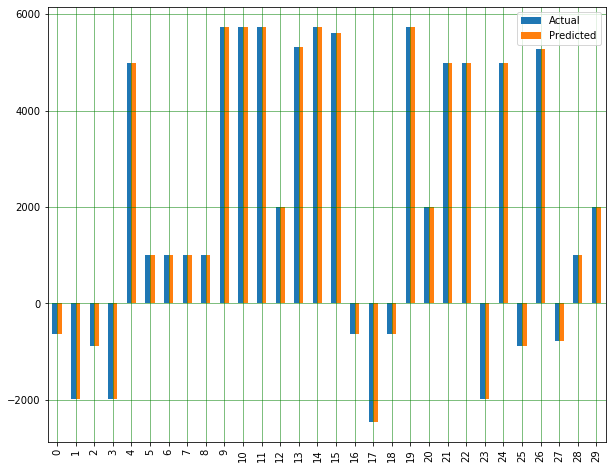

In [15]:
y_pred = regressaoLinear.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Decision Tree Regressor

In [16]:
from sklearn.tree import DecisionTreeRegressor

In [17]:
regressaoArvores = DecisionTreeRegressor(random_state = 0)
regressaoArvores.fit(x_treino, y_treino)
score = regressaoArvores.score(x_treino, y_treino)
previsoes = regressaoArvores.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [18]:
print('Decision Tree Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

Decision Tree Regression
Mean absolute error: 15.320281769203566
Mean squared error: 4842.8303507333
Score: 1.0


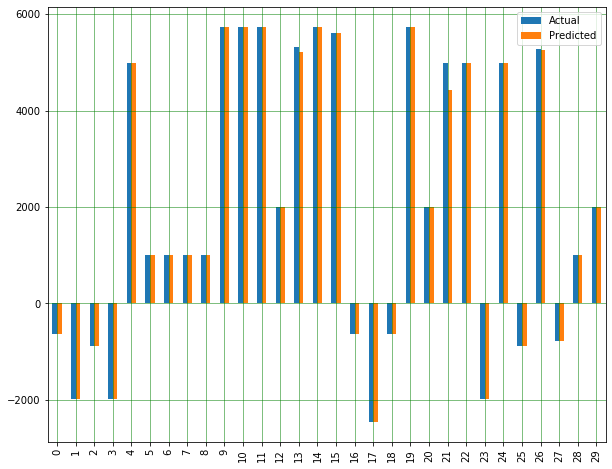

In [19]:
y_pred = regressaoArvores.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
regressaoRandomForest = RandomForestRegressor(n_estimators = 100)
regressaoRandomForest.fit(x_treino, y_treino)
score = regressaoRandomForest.score(x_treino, y_treino)
previsoes = regressaoRandomForest.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [22]:
print('Random Forest Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

Random Forest Regression
Mean absolute error: 13.263368989663835
Mean squared error: 2105.1791537251142
Score: 0.9999545587222898


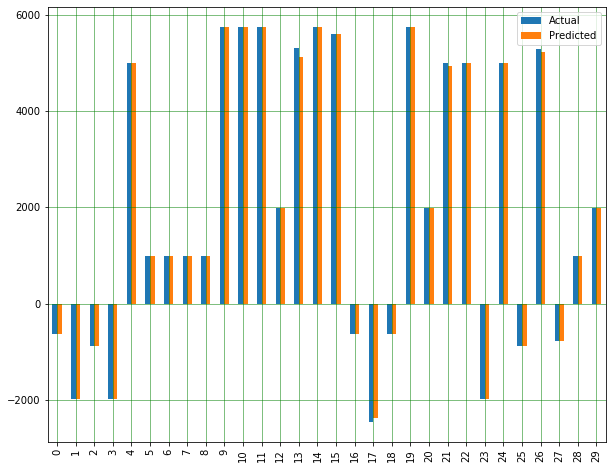

In [23]:
y_pred = regressaoRandomForest.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Support Vector Regression

In [24]:
from sklearn.svm import SVR

In [25]:
regressorSVM = SVR(kernel = 'rbf')
regressorSVM.fit(x_treino, y_treino)
score = regressorSVM.score(x_treino, y_treino)
previsoes = regressorSVM.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [26]:
print('SVR Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

SVR Regression
Mean absolute error: 2412.548039503339
Mean squared error: 8768858.759938821
Score: -0.01672405093687801


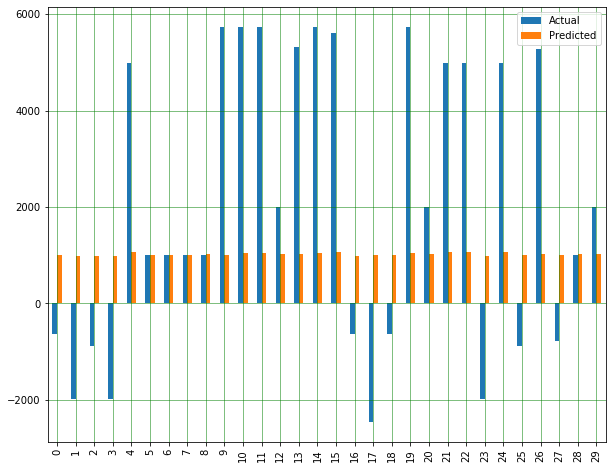

In [27]:
y_pred = regressorSVM.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Plot Todas as Regressões

In [28]:
params = {'legend.fontsize': 'large',          
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

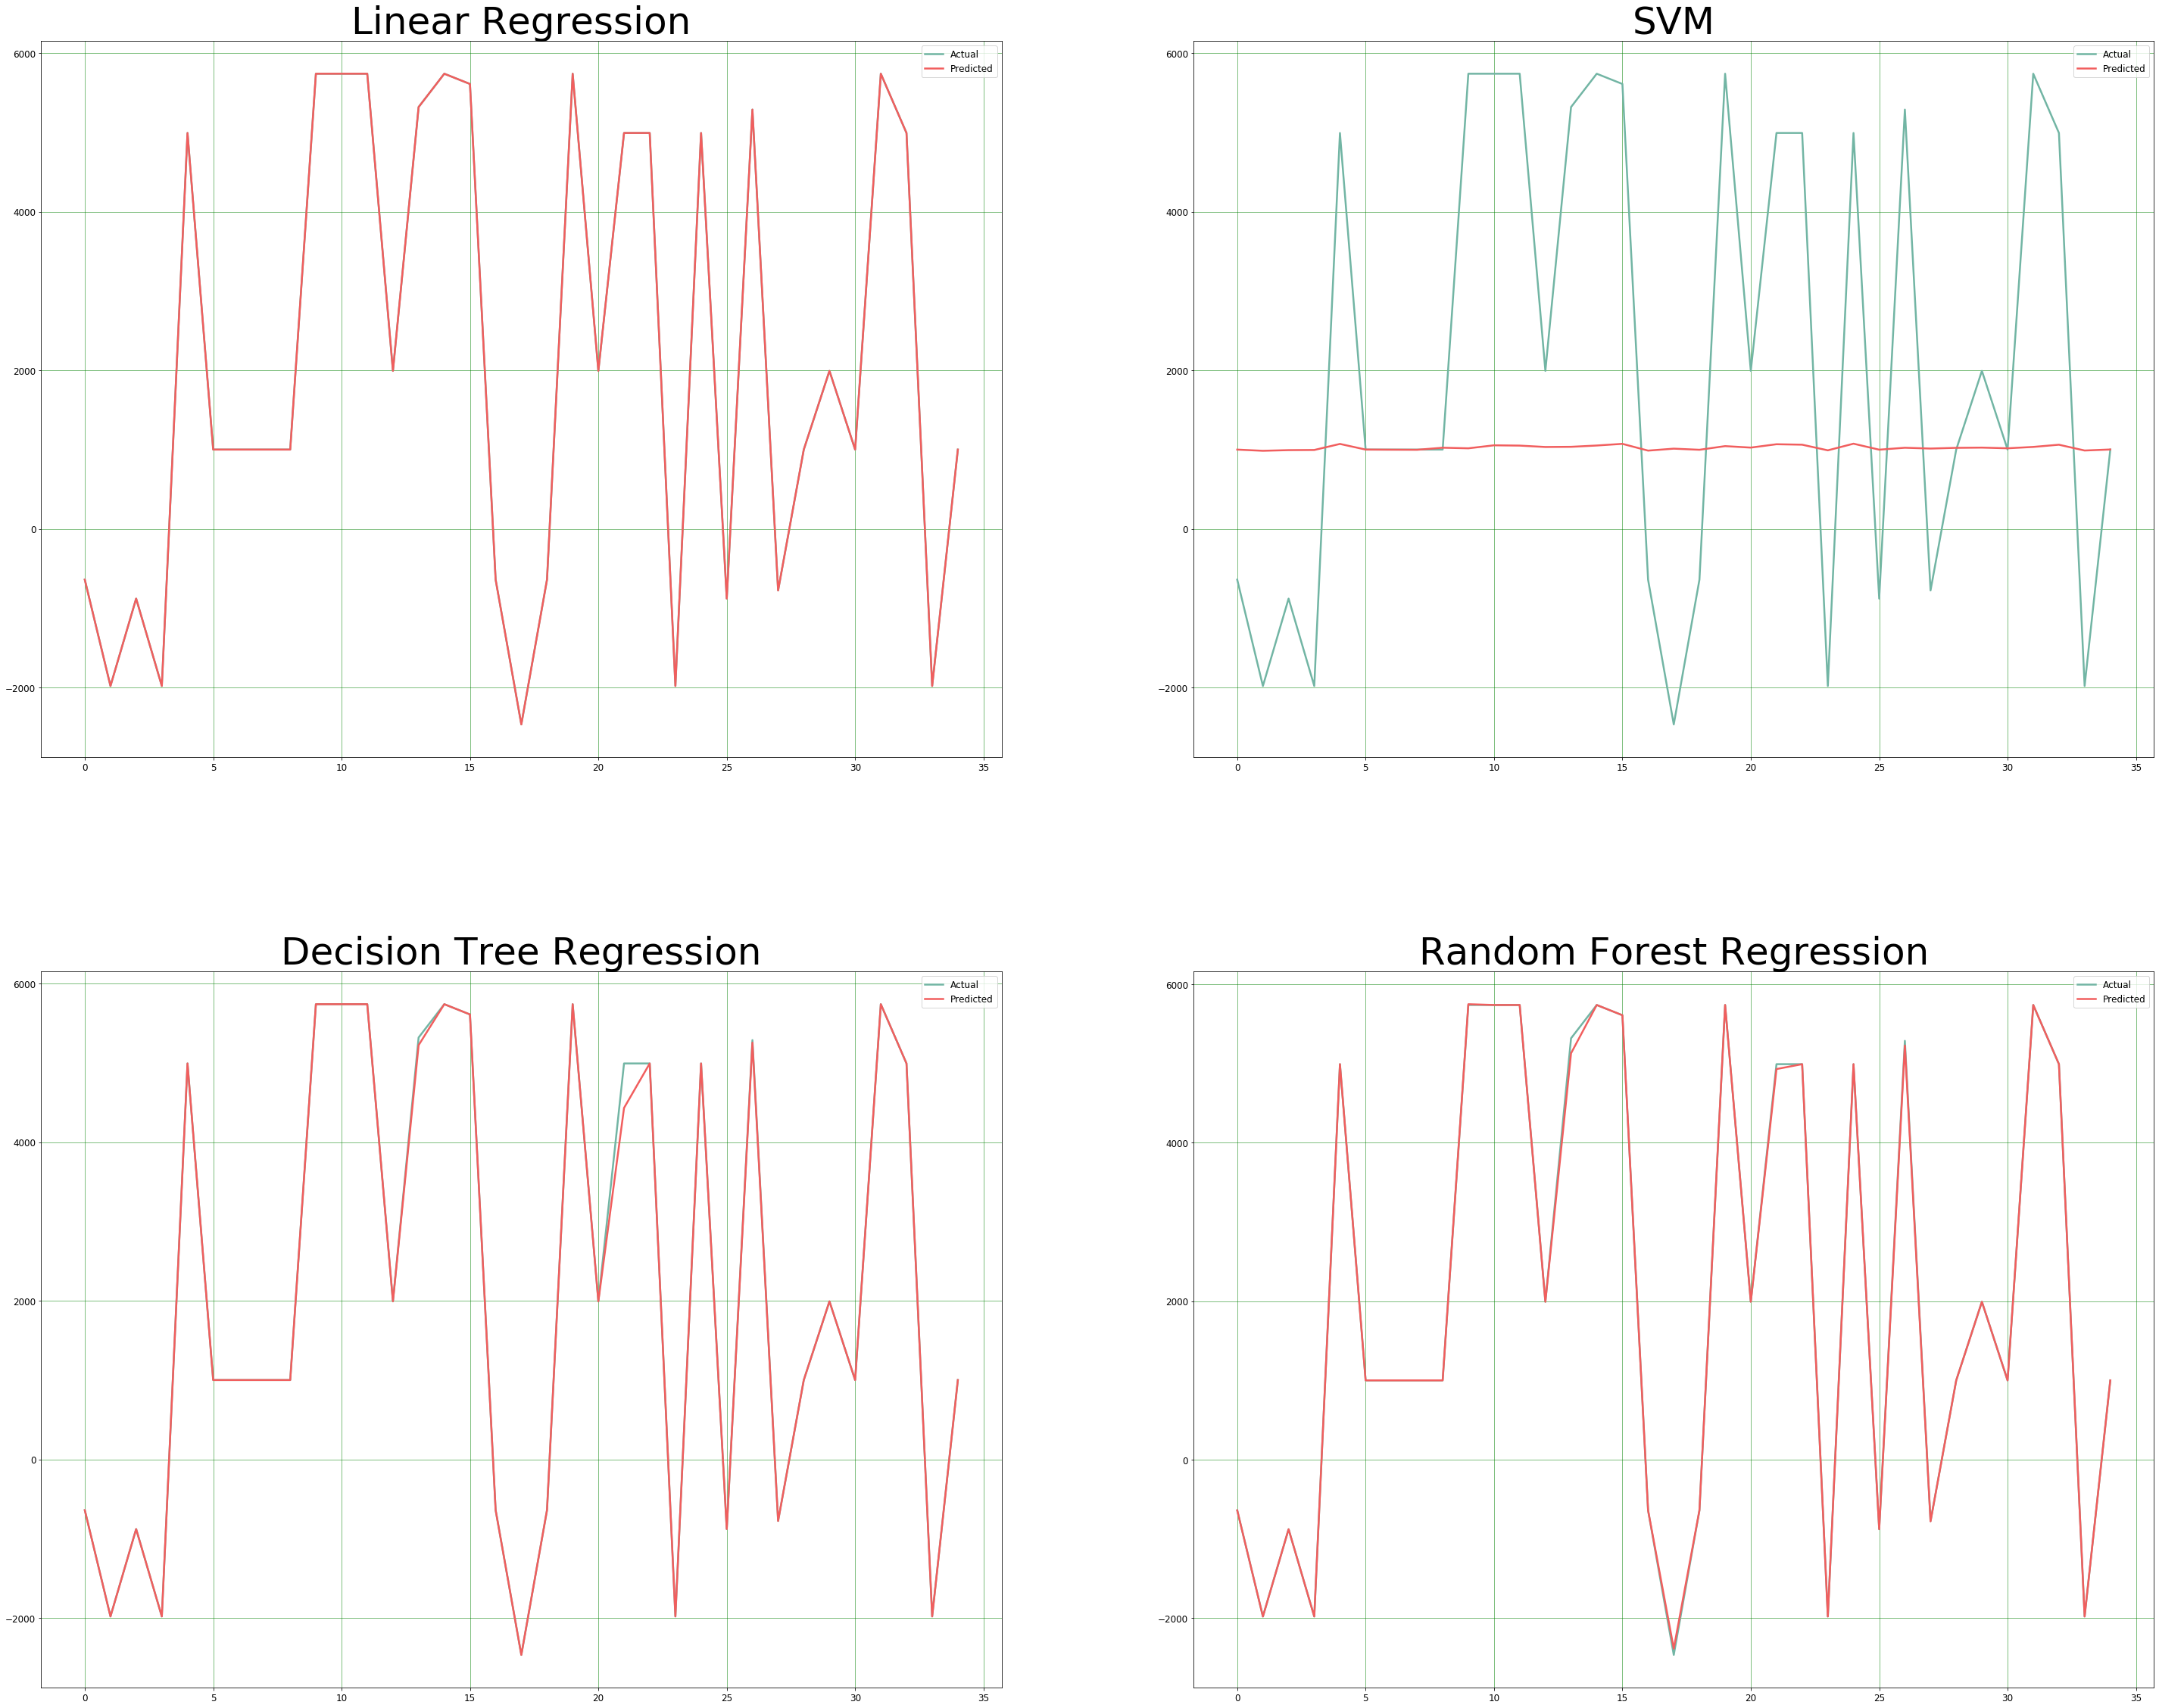

In [29]:
fig, eixos = plt.subplots(nrows=2, ncols=2, figsize=(50,40))

eixos[0,0].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[0,0].plot(pd.DataFrame({'y': regressaoLinear.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[0,0].set_title('Linear Regression', fontsize=50)
eixos[0,0].legend(loc="upper right")
eixos[0,0].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[0,0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

eixos[0,1].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[0,1].plot(pd.DataFrame({'y': regressorSVM.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[0,1].set_title('SVM', fontsize=50)
eixos[0,1].legend(loc="upper right")
eixos[0,1].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[0,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

eixos[1,0].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[1,0].plot(pd.DataFrame({'y': regressaoArvores.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[1,0].set_title('Decision Tree Regression', fontsize=50)
eixos[1,0].legend(loc="upper right")
eixos[1,0].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[1,0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

eixos[1,1].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[1,1].plot(pd.DataFrame({'y': regressaoRandomForest.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[1,1].set_title('Random Forest Regression', fontsize=50)
eixos[1,1].legend(loc="upper right")
eixos[1,1].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[1,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.3)
#plt.show()
plt.savefig('graphs.png')